In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

In [103]:
#read dataset 
df= pd.read_excel('Superstore2017.xls')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [104]:
#shape
df.shape

(9994, 21)

In [105]:
#duplicates and nulls
print(df.duplicated().any())
df.isnull().sum()


False


Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

### Data Overview

1. The Dataset has 9994 rows and 21 rows 
2. No duplicates or null entries in the dataset

In [106]:
#data types 
df.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [107]:
#choose the category to forecast
df['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [108]:
df= df.loc[df['Category']=='Technology']

df.sample(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
11,12,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,911.424,4,0.2,68.3568
8654,8655,CA-2014-142769,2014-09-13,2014-09-13,Same Day,RP-19390,Resi Pölking,Consumer,United States,Seattle,...,98103,West,TEC-AC-10003399,Technology,Accessories,Memorex Mini Travel Drive 64 GB USB 2.0 Flash ...,144.960,4,0.0,60.8832
7221,7222,US-2017-104437,2017-01-27,2017-01-31,Standard Class,TG-21310,Toby Gnade,Consumer,United States,New York City,...,10035,East,TEC-PH-10000193,Technology,Phones,Jensen SMPS-640 - speaker phone,137.940,3,0.0,35.8644
4331,4332,CA-2017-107909,2017-09-01,2017-09-06,Standard Class,SS-20875,Sung Shariari,Consumer,United States,Redmond,...,98052,West,TEC-AC-10001998,Technology,Accessories,Logitech LS21 Speaker System - PC Multimedia -...,19.990,1,0.0,6.7966
9764,9765,CA-2014-123855,2014-06-18,2014-06-23,Standard Class,MC-18100,Mick Crebagga,Consumer,United States,Los Angeles,...,90036,West,TEC-PH-10000215,Technology,Phones,Plantronics Cordless Phone Headset with In-lin...,139.800,5,0.2,12.2325


In [109]:
#for the forecast we focus on the sales and the order date
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [110]:
#select the columns to drop 
cols =['Row ID', 'Order ID','Ship Date', 'Ship Mode','Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State','Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category','Product Name', 'Quantity', 'Discount', 'Profit']

In [111]:
df= df.drop(cols,axis=1)

df.head(3)


,Order Date,Sales
7,2014-06-09,907.152
11,2014-06-09,911.424
19,2014-08-27,213.480


In [116]:
#resample the dataset
df=df.resample('M',on='Order Date').mean()
df = df.reset_index()
df.head(5)

,Order Date,Sales
0,2014-01-31,349.254444
1,2014-02-28,201.063750
2,2014-03-31,1477.780636
3,2014-04-30,353.670538
4,2014-05-31,355.550963


In [117]:
#Prophet needs the column names as 'ds' and 'y'
df.columns =['ds','y']
df.head(5)

,ds,y
0,2014-01-31,349.254444
1,2014-02-28,201.063750
2,2014-03-31,1477.780636
3,2014-04-30,353.670538
4,2014-05-31,355.550963


In [119]:
#create a model and fit the dataset
model= Prophet()
#fit the dataset
model.fit(df)

09:58:06 - cmdstanpy - INFO - Chain [1] start processing
09:58:06 - cmdstanpy - INFO - Chain [1] done processing


In [120]:
df.tail(5)

,ds,y
43,2017-08-31,489.421167
44,2017-09-30,292.854380
45,2017-10-31,576.415140
46,2017-11-30,536.761000
47,2017-12-31,293.132133


In [127]:
#define the period for forecast
#create a list to add the dates
f_list= list()
for i in range(1,13):
    date='2017-%02d' % i
    f_list.append([date])
#create a dataframe from the list
f_df=pd.DataFrame(f_list)
f_df.columns=['ds']

In [128]:
#forecast using model, pass the new dataframe to the model
forecast= model.predict(f_df)

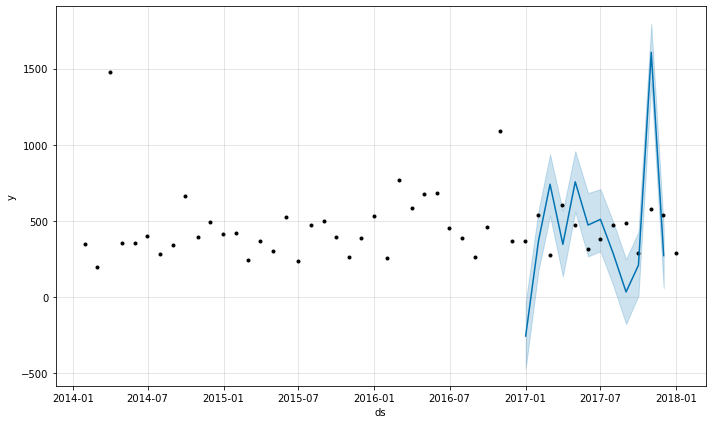

In [129]:
#plot the forecast
model.plot(forecast)
plt.show()

### Out of sample Forecast

In [130]:
#make the forecast period out of the sample
#define the period for forecast
#create a list to add the dates
f_list= list()
for i in range(1,13):
    date='2018-%02d' % i
    f_list.append([date])
#create a dataframe from the list
f_df=pd.DataFrame(f_list)
f_df.columns=['ds']

In [131]:
forecast=model.predict(f_df)

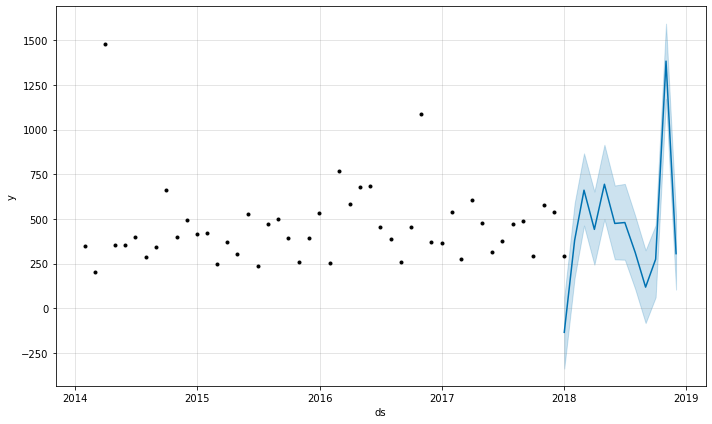

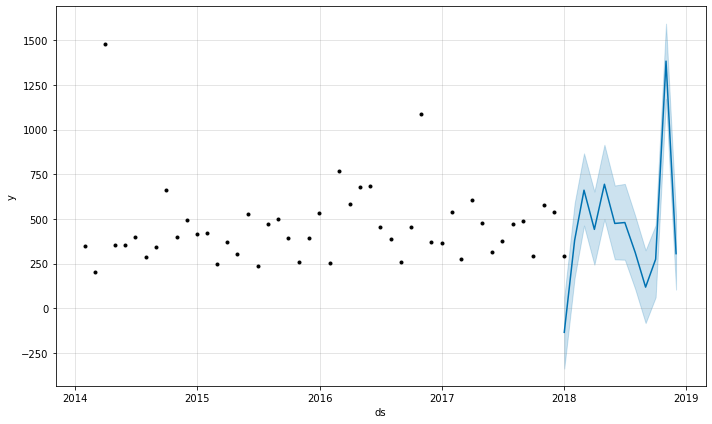

In [132]:
#plot the forecast
model.plot(forecast)

### Evaluate The forecast model

In [133]:
#create test dataset , remove the last 12 months
train_df= df.drop(df.index[-12:])
train_df.tail()

,ds,y
31,2016-08-31,261.416270
32,2016-09-30,457.668120
33,2016-10-31,1087.357724
34,2016-11-30,371.795329
35,2016-12-31,365.946918


In [134]:
#create the model
model=Prophet()
#fit the dataset to the model
model.fit(train_df)

10:57:33 - cmdstanpy - INFO - Chain [1] start processing
10:57:33 - cmdstanpy - INFO - Chain [1] done processing


In [136]:
#define the period for the prediction
train_list= list()
for i in range(1,13):
    date='2017-%02d' % i
    train_list.append([date])
train_list= pd.DataFrame(train_list)
train_list.columns= ['ds']
#use the model to make a forecast
forecast_train=model.predict(train_list)

In [137]:
#define a MAE function
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [138]:
#calculate MAE between expected and predicted values for december
y_true =df['y'][-12:].values
y_pred =forecast_train['yhat'].values
mae= mae(y_true,y_pred)
print('MAE: %.3f' % mae)

MAE: 359.183


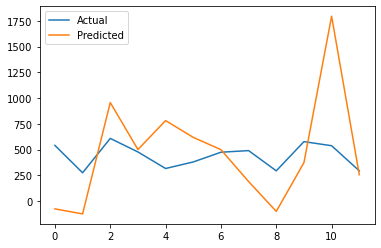

In [139]:
#plot the y_true and the y_pred
plt.plot(y_true,label='Actual')
plt.plot(y_pred,label='Predicted')
plt.legend()
plt.show()

## The end